In [1]:
import numpy as np

import matplotlib.pyplot as plt
import scipy

# %matpnlotlib notebook 
%matplotlib inline 

# generic stochastic quantum channel

In [2]:
import qutip as qutip

# https://qutip.readthedocs.io/en/latest/guide/guide.html
# https://qutip.org/qutip-tutorials/

fileroot = 'walk_05_'

In [206]:
# check to see if an np.array square matrix m is unitary 
def is_unitary(m):
    bb = np.allclose(np.eye(len(m)), m.dot(m.T.conj()), rtol=1e-05, atol=1e-08) # for square numpy array m
    return bb  # returns boolean
    
# given a Hermitian operator qutip.Qobj Hop on a 2 state system
# create an tensor product n_qubit unitary that is identity except j, j+1 qubits
# were we put the operator e^(i epsilon Hop)
# does not use any globals
def mk_interaction_small(n_qubits,Hop,epsilon,j):
    if (j <0):
        print('err j<0')
        return 0
    if (j > n_qubits-2):
        print('err j<n_qubits-2')
        return 0
    if (Hop.check_herm() != True):
        print('mk_interaction_small: Warning: Hop is not Hermitian')

    U_small_np = scipy.linalg.expm(1j*epsilon*Hop.full())  # make a small near identity transformation 
    # using scipy's expm with the hope that it will more likely to be actually unitary, the result is a numpy array 
    U_small =  qutip.Qobj(U_small_np,dims = [[2, 2], [2, 2]])
    if (U_small.isunitary != True):
        print('mk_interaction_small: U_small is not unitary')
        
    # now we make embed the interaction in the full tensor product space 
    id2 = qutip.qeye(2)  # identity 
    op_list = []  # create a list of operators 
    for k in range(0,j):
        op_list = np.append(op_list,id2)
    op_list = np.append(op_list,U_small)
    for k in range(j+2,n_qubits):
         op_list = np.append(op_list,id2)
    U_int = qutip.tensor(op_list)  # tensor product 
    if (U_int.isunitary != True):
        print('mk_interaction_small: U_int is not unitary')
    return U_int


# do a reset on density operator rho on last qubit 
# with trace instead of Kraus ops
def reset_channel(rho,n_qubits):
    ilist = np.arange(0,n_qubits-1)  # keep all but last one 
    rho_short = rho.ptrace(ilist)    # partial trace out the last qubit 
    ket0 = qutip.basis(2, 0) # |0>
    K0 = ket0*ket0.dag() #|0><0|
    op_list = [ rho_short, K0] 
    rho_new =qutip.tensor(op_list) # make new_rho = (tr_n-1 rho) \otimes |0><0|
    return rho_new

#do a depolarization channel on first qubit 
def depol_channel(rho,n_qubits):
    ilist = np.arange(1,n_qubits) # keep all but first one
    rho_short = rho.ptrace(ilist)    # trace out first qubit 
    id2 = qutip.qeye(2)  # identity op
    op_list = [ id2/2,rho_short ] 
    rho_new =qutip.tensor(op_list)  # make new_rho = I/2 \otimes (tr_0 rho) 
    return rho_new

In [219]:
# class definition for carrying out a stochastic random walk channel 
# random op on first qubit
# reset on last qubit
# in between exponentially small versions of an 2qubit operator that we pass  
# calls above routines reset_channel(), mk_interaction_small(), is_unitary(), depol_channel()
class walkit():
    # init: arguments:
    #  n_qubits:  number of qubits
    #  epsilon:  strength of 2qubit local interaction  - can be an array  length n_qubits - 1
    #  H_2bits:  Hermitian 2qubit interaction operator qutip.Qobj
    #  sim_label:  a string label for simulation
    #  inter_type :   a string specifying type of interaction 
    #  inter_label:   a label for the interaction operator 
    #  alpha : if 1 then we only have random channel, if less than 1 you can dilute the random channel with identity or depolarization
    #  beta :  add in a fraction of depolarization channel 
    def __init__(self,n_qubits,epsilon,H_2bits,sim_label,inter_type='seq',inter_label='Swap',alpha=1.0,beta=0.0):
        self.n_qubits = n_qubits  # number of qubits in chain 
        self.N = 2**n_qubits
        if (isinstance(epsilon, float)):
            self.epsilon_arr = epsilon + np.zeros(n_qubits-1)  # perturbation parameter or parameters 
            self.epsilon = epsilon
        else:
            self.epsilon_arr = epsilon
            if (len(epsilon) < n_qubits - 1):
                print("epsilon array too short")
        self.H_2bits = H_2bits  # Hermitian op qutip.Qobj
        self.sim_label = sim_label  # a string label 
        self.inter_type = inter_type  # interaction type 
        self.inter_label = inter_label  # interaction nane label 
        
        self.init_rho()  # initialize to the ground state, makes self.rho
        self.mk_int_prod()  # make an interaction unitary  self.U_int_prod  using self.epsilon_arr and self.H_2bits
        self.alpha = alpha  # strength of random channel, if less than 1 dilute it 
        self.beta = beta  # if not equal to zero then dilute random change by some fraction of depolarization channel 
        if (beta <0):
            print('error: beta should be positive')
        if (alpha <0):
            print('error: alpha should be positive')
        if (beta >1):
            print('error: beta should be less than 1')
        if (alpha >0):
            print('error: alpha should be less than 1')
        if (alpha+beta>1):
            print('error: alpha+beta should be less than 1')

    # create density operator from ground state in all qubits 
    # creates self.rho and self.rho_init
    def init_rho(self):
        ket0 = qutip.basis(2, 0)
        op_list = []
        for j in range(self.n_qubits):
            op_list = np.append(op_list,ket0)
        psi  = qutip.tensor(op_list) # this is a ket, not an operator 
        self.rho = qutip.ket2dm(psi)  # make density operator from statevector psi
        self.rho_init = self.rho  # keep a copy
        
    # make an interaction unitary of a product of near identity operators based on a 2 qubit operator self.H_2bits
    # creates self.U_int_prod and dagger self.U_int_prod_dagger
    # this is a sequential product of 2qubit operators 
    def mk_int_prod(self):
        
        if (self.inter_type == 'seq'):  # we use a sequential product of interactions with strengths epsilon_arr
            U_int_prod  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[0],0) # external routine 
            # this is a n_qubit operator that has e^{i epsilon H_2bits} operating on first two qubits
            # and is identity in the rest 
            for j in range(1,self.n_qubits-1):  # from 1 to n-1
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod = U_int*U_int_prod   # is a product of all these interactions operators 
                
            self.U_int_prod = U_int_prod  # returns nothing, but creates self.U_int_prod

        if (self.inter_type == 'brick'): # even and odd bricks 
            U_int_prod_even = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[0],0) # external routine 
            U_int_prod_odd  = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[1],1) 
            for j in range(2,self.n_qubits-1,2):  # from 2 to n-1, in non-touching but proximate pairs
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod_even = U_int*U_int_prod_even   # is a product of all these interactions operators, pairs
            for j in range(3,self.n_qubits-1,2):  # from 3 to n-1, in non-touching but proximate pairs
                U_int = mk_interaction_small(self.n_qubits,self.H_2bits,self.epsilon_arr[j],j)    # sequential local interactions
                U_int_prod_odd = U_int*U_int_prod_odd   # is a product of all these interactions operators, pairs
            U_int_prod = U_int_prod_odd*U_int_prod_even

            self.U_int_prod = U_int_prod  # returns nothing, but creates self.U_int_prod

        self.U_int_prod_dagger = self.U_int_prod.dag()  # store the self-adjoint 

        # checks!
        if (self.U_int_prod.isunitary != True):
            print('warning: U_int_prod is not unitary!')
        bb = is_unitary(self.U_int_prod.full())
        if (bb != True):
            print('warning: U_int_prod is not unitary (bb)')
                  
    # interactions then reset then random, then update rho
    def do_channel(self):

        new_rho = self.U_int_prod * (self.rho * self.U_int_prod_dagger)  # interactions 
        new_rho2 = reset_channel(new_rho,self.n_qubits)  # reset channel
        U_rand = self.create_rand_op(0) # random op in first qubit, internal routine 
        U_rand_dagger = U_rand.dag()
        # U_rand must be remade every time this routine is called 
        new_rho3_a = U_rand * (new_rho2 * U_rand_dagger) # random 
        if (self.beta >0):
            new_rho3_b = depol_channel(new_rho2,self.n_qubits)  # depol 
        else :
            new_rho3_b = 0.0
        new_rho4 = self.alpha*new_rho3_a + self.beta*new_rho3_b + (1- self.alpha - self.beta)*new_rho2   
        # allow dilution of random channel by depolarization or and identity 
        # sum with last begin identity 
        self.rho = new_rho4  # update density operator 

    # iterate ntimes x nstore
    # store traced density operators nstore times 
    def iterate(self,ntimes,nstore,use_super=False,do_checks=False):
        rho_store = np.zeros([nstore,self.n_qubits,2,2],dtype=complex)
        mx_store = np.zeros([nstore,self.n_qubits])
        my_store = np.zeros([nstore,self.n_qubits])
        mz_store = np.zeros([nstore,self.n_qubits])
        for k in range(nstore):
            for m in range(ntimes):  # iterate ntimes 
                self.do_channel()
            for j in range(self.n_qubits):
                rho_j = self.rho.ptrace(j)  # partial trace all qubits but the jth one
                rho_store[k,j,:,:] = rho_j.full()  # try to store each partial trace 
                mx = np.real( (rho_j*qutip.sigmax()).tr())  # measure x,y,z in each qubit
                my = np.real( (rho_j*qutip.sigmay()).tr())  #
                mz = np.real( (rho_j*qutip.sigmaz()).tr())
                mx_store[k,j] = mx
                my_store[k,j] = my
                mz_store[k,j] = mz
            if (do_checks==True):
                rhot = np.trace(self.rho.full())
                if (rhot > 1.2):
                    print('warning: trace rho >1.2')  # if you have screwed up badly!
                    break
        self.rho_store = rho_store
        self.mx_store = mx_store  # store some polarization measurements
        self.my_store = my_store
        self.mz_store = mz_store
        self.ntimes = ntimes
        self.nstore = nstore

    # create a unitary operator that is a tensor product of identity on all qubits but the j-th one 
    # and is random Haar on the j-th one
    # indexing j=0 to n_qubits-1
    # does not use any globals
    # returned operater is a unitary on full n_qubit system
    def create_rand_op(self,j):
        id2 = qutip.qeye(2)  # identity on a single qubit 
        R2 = qutip.random_objects.rand_unitary(2)  # Haar random on 2 state  (single qubit)
        op_list = []  # create a list of operators  that is n_qubits long
        for k in range(0,j):
            op_list = np.append(op_list,id2)  # insert identities 
        op_list = np.append(op_list,R2)  # put in the random op
        for k in range(j+1,self.n_qubits):
            op_list = np.append(op_list,id2) # more identities 
        U_rand = qutip.tensor(op_list)   # tensor product of n_qubit number of 2 state systems 
        return U_rand

    # for iterations stored past index i1 return means and standard deviations for each qubit polarizations 
    def simstats(self,i1):
        self.muz = np.zeros(self.n_qubits)  # not bothering with mean of x,y because they are close to zero
        self.sigz = np.zeros(self.n_qubits)
        self.sigx = np.zeros(self.n_qubits)
        self.sigy = np.zeros(self.n_qubits)
        for j in range(self.n_qubits):
            mz = np.squeeze(self.mz_store[i1:,j])
            mx = np.squeeze(self.mx_store[i1:,j])
            my = np.squeeze(self.my_store[i1:,j])
            self.muz[j] = np.mean(mz)  # store mean of z polarizations 
            self.sigz[j] = np.std(mz)   # store standard deviation of z polarizations
            
            self.sigx[j] = np.std(mx)   # store standard deviation of x polarizations
            self.sigy[j] = np.std(my)   



In [248]:
# make a figure showing -<sigma_z> for each qubit (tracing out the others)
# imax is a maximum limit 
# mtype= 'x','y','z' determines whether -<Y> -<Z> or -<X> is plotted 
# sim is a walkit class of channel simulation 
def sigz_fig(sim,imax=0,mtype='z',ablabel=''):
    colorlist = ['red','orange','gold','green','blue','violet','gray']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])  # used in x axis for iterations
    nit = np.arange(len(mz0)) # used in x axis for iterations
    jmax = len(mz0)
    if (imax >0) and (imax < jmax):
        jmax = imax
   
    for j in range(sim.n_qubits):
        if   (mtype =='x'):
            mm = np.squeeze(sim.mx_store[0:,j])
        elif (mtype =='y'):
            mm = np.squeeze(sim.my_store[0:,j])
        else: # (mtype =='z'):    
            mm = -np.squeeze(sim.mz_store[0:,j]) # notice minus sign is here!!!!!
        #print(np.mean(mz[i0:]),np.std(mz[i0:]))
        ilabel = '{:d}'.format(j)
        ax.plot(nit,mm[0:jmax],'.',color=colorlist[j%nc],ms=1,label=ilabel)  
        
    ax.set_xlabel('iteration',fontsize=12)
    yl = r'$p_' + mtype + '$ each qubit'
    if (mtype =='z'):
        yl = '-' + yl
    ax.set_ylabel(yl,labelpad=-1,fontsize=12)
    ax.text(-0.2,0.95, ablabel,transform=ax.transAxes,fontsize=14)
    fig_label = sim.inter_label + r',$\epsilon$={:.2f},'.format(sim.epsilon)+ r'$n$={:d}'.format(sim.n_qubits)
    
    ax.text(0.5,0.97, fig_label,transform=ax.transAxes,fontsize=14,ha='center',va='top')
    ax.legend(markerscale=1.9,borderpad=0.1,labelspacing=0.1,handlelength=0.5,handletextpad=0.1,borderaxespad=0.1,loc='top right')
    
    ofile = fileroot+sim.sim_label+'_s' + mtype + '.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

#sigz_fig(sim1,1000,'z',ablabel='a)')

# plot histograms of polarization measurements
# only using from i0 onwards 
def plt_hists(sim,i0,mtype='z',ablabel=''):
    colorlist = ['red','orange','gold','green','blue','violet','gray','brown']
    nc = len(colorlist)
    ls_list = ['-', '--', '-.', ':']
    nls = len(ls_list)
    
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)

    lws = np.linspace(1,2,sim.n_qubits)

    bins=np.linspace(-0.4,0.4,40)
    
    for j in range(sim.n_qubits-1):
        if   (mtype =='x'):
            mz = np.squeeze(sim.mx_store[i0:,j])
            
        elif (mtype =='y'):
            mz = np.squeeze(sim.my_store[i0:,j])
        else: # (mtype =='z'):    
            mz = np.squeeze(sim.mz_store[i0:,j])
            bins=np.linspace(-1,0.5,40)
        ax.hist(-mz,bins=bins,density=True,edgecolor=colorlist[j%nc],alpha=1,histtype='step', linewidth=lws[j]) 
        # ,linestyle = ls_list[j%nls])
        ax.hist(-mz,bins=bins,density=True,facecolor=colorlist[j%nc],alpha=0.3,histtype='stepfilled', linewidth=1)

    ax.set_xlim([min(bins),max(bins)])
    yl = r'-$p_' + mtype + '$'
    ax.set_xlabel(yl,fontsize=12)
    ax.set_ylabel('distribution',fontsize=12)
    ax.text(-0.15,0.95, ablabel,transform=ax.transAxes,fontsize=14)
    fig_label = sim.inter_label +'\n'+ r'$\epsilon$={:.2f}'.format(sim.epsilon)+ '\n'+r'$n$={:d}'.format(sim.n_qubits)
    ax.text(0.9,0.97, fig_label,transform=ax.transAxes,fontsize=14,ha='right',va='top')
    
    ofile = fileroot+sim.sim_label + 'h' + mtype +'.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

#plt_hists(sim1,1000,mtype='z')
        

In [191]:
# make a 2 qubit swap operator 
Qswap = qutip.Qobj([[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)
#Qswap.full() gives array

# this is the same thing as sigma_+^0 sigma_-^2 + sigma_-^0 sigma_+^2
Qswap_short = qutip.Qobj([[0, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True)  # notice no terms on diagonal, is not unitary

# controlled not with first bit the control bit 
QCnotC0 =  qutip.Qobj([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]],
            dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# controlled not with second bit the control bit 
QCnotC1 =  qutip.Qobj([[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0]],
             dims = [[2, 2], [2, 2]],
            isherm=True,isunitary=True)

# the Heisenberg spin interaction (sum of pairs of Paulis)
# this is the same thing as sigma_+^1 sigma_-^2 + sigma_-^1 sigma_+^2 + sigma_z^1 sigma_z^2
# which is sum_i sigma_i^1 sigma_i^2
QHeis = qutip.Qobj([[1, 0, 0, 0], [0, -1, 2, 0], [0, 2, -1, 0], [0, 0, 0, 1]],
            dims = [[2, 2], [2, 2]], isherm=True)


-0.0001532237828136649 0.041609349599824826
0.3660898392499843 0.030132714315452835
0.4576889471775778 0.023506015231388688
0.5361410118767386 0.023050970871680832
0.6235506356211232 0.02965811505754241
0.9999999999986597 3.533570434941961e-13
walk_05_T1_sz.png


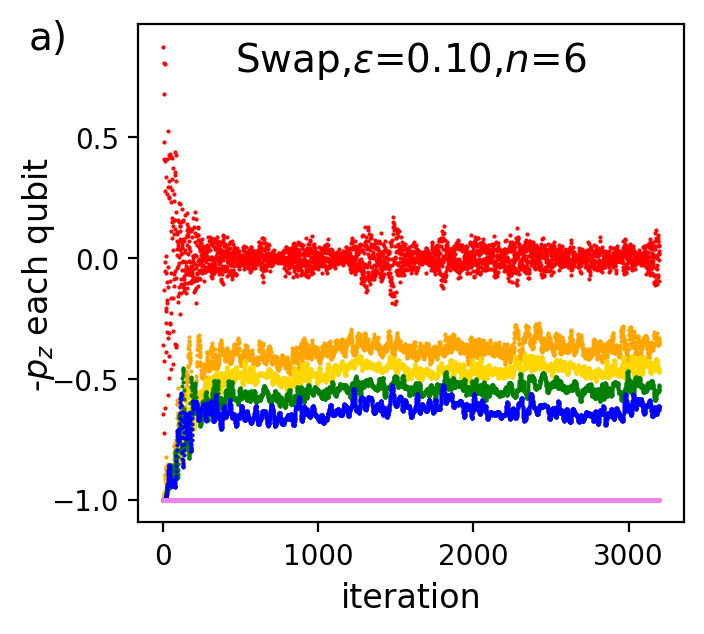

In [233]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'T1'
inter_label = 'Swap'
tsim1 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label,alpha=0.99,beta=0.0)
mtimes = 1 
nstore = 400*8
tsim1.iterate(mtimes,nstore)  # 
#sim1.simstats(1000)
sigz_fig(tsim1,mtype='z',ablabel='a)')

In [245]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1'
inter_label = 'Swap'
sim1 =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label)
mtimes = 1 
nstore = 400*8
#fig_label = r'SWAP,' + '\n'+'$\epsilon={:.1f}$\n $n$={:d}'.format(epsilon,n_qubits)
sim1.iterate(mtimes,nstore)  # 
sim1.simstats(1000)

In [249]:
sigz_fig(sim1,mtype='z',ablabel='a)')

ValueError: 'top right' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

walk_05_S1hz.png


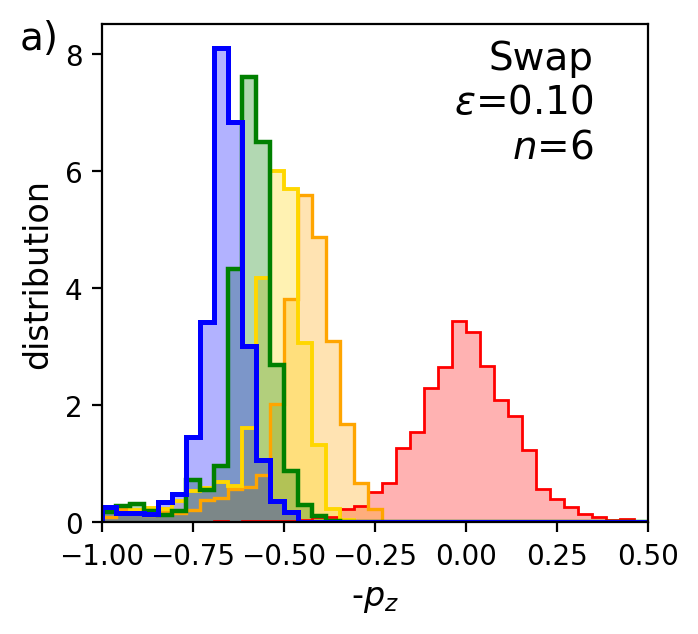

In [213]:
plt_hists(sim1,1000,mtype='z',ablabel='a)')  # last qubit not plotted!

walk_05_S1hx.png


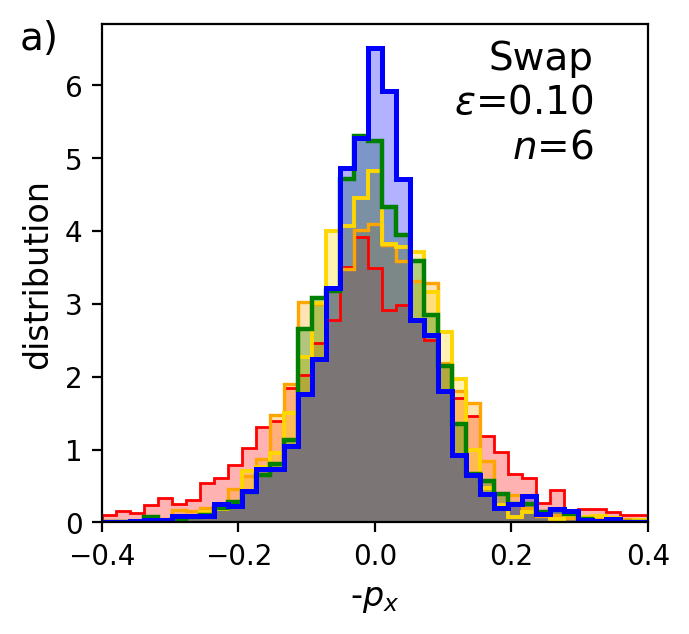

walk_05_S1hy.png


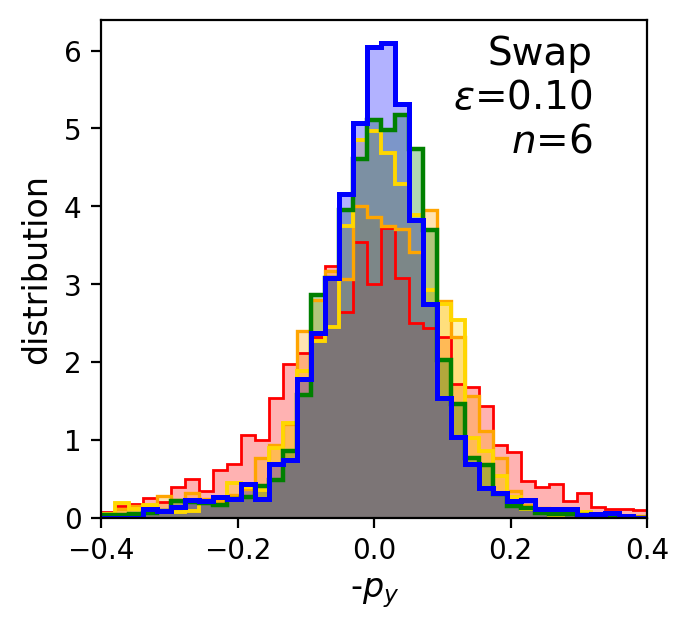

In [214]:
plt_hists(sim1,1000,mtype='x',ablabel='a)')
plt_hists(sim1,1000,mtype='y')

-0.0011749987775580516 0.10722107074685544
-0.007871133194933115 0.07887451515569867
-0.009529787548769432 0.06680945800065788
-0.006709755338007847 0.06041586459877809
-0.0026824999269647746 0.05697038627539445
0.0 0.0
walk_05_S1_sy.png


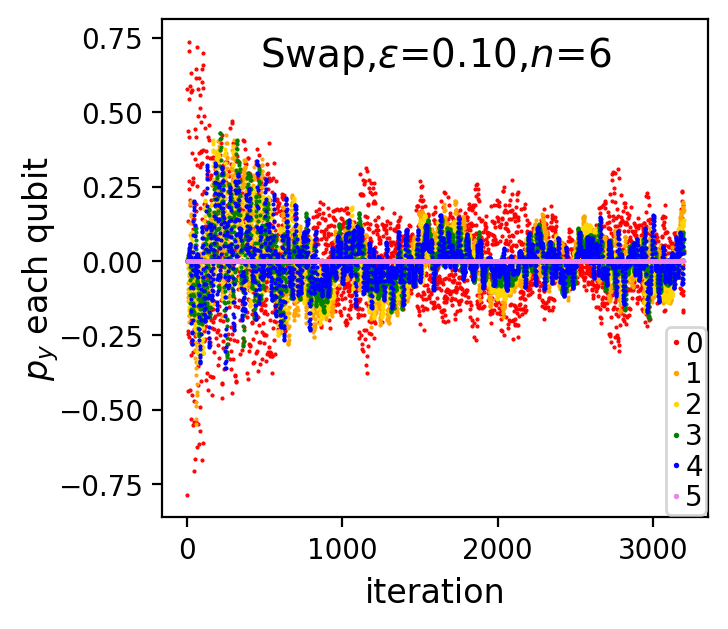

In [242]:
sigz_fig(sim1,1000,'y')

In [202]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S1b'
inter_label = 'Swap'
sim1b =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq',inter_label=inter_label)
mtimes = 1 
nstore = 400*8*4
sim1b.iterate(mtimes,nstore)  # 
sim1b.simstats(2000)

-0.0012430477487791302 0.11479048838229997
-0.39908894508650117 0.08479880363161095
-0.4892010055265595 0.06835185497403352
-0.5549458085442739 0.062423101170245424
-0.638637548111075 0.05619896206135086
-1.0000000000018927 1.2350978065866706e-12
walk_05_S1b_sz.png


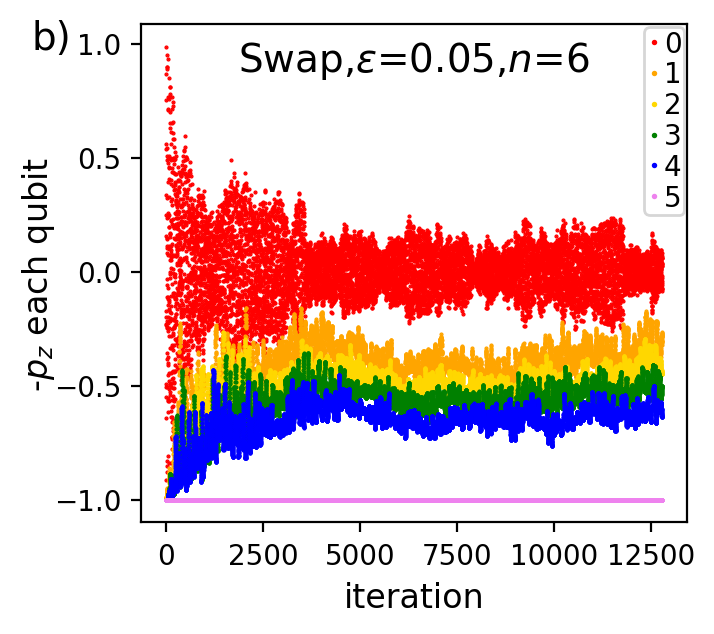

In [241]:
sigz_fig(sim1b,1000,ablabel='b)')

walk_05_S1bhz.png


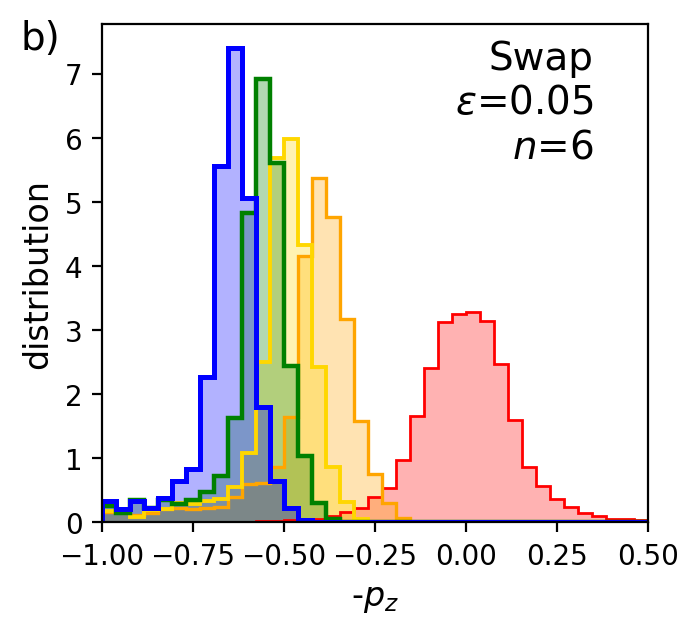

In [204]:
plt_hists(sim1b,4000,mtype='z',ablabel='b)')

walk_05_S1bhx.png


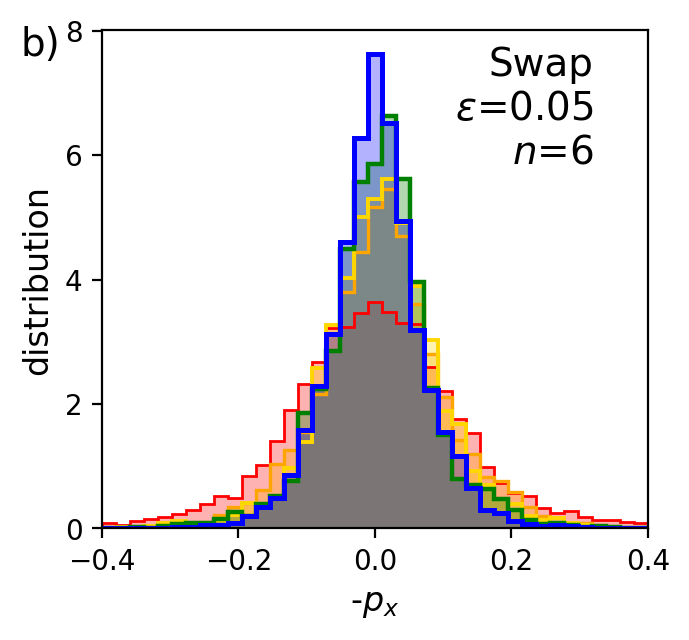

In [205]:
plt_hists(sim1b,4000,mtype='x',ablabel='b)')

0.0038334724063582453 0.10852212163531436
0.35952970443225557 0.07107892941931027
0.47398638660228554 0.05989089833178162
0.5837045573444993 0.05955668489980238
0.9999999999988656 3.3706311098262174e-13
walk_04_S1c_sz.png


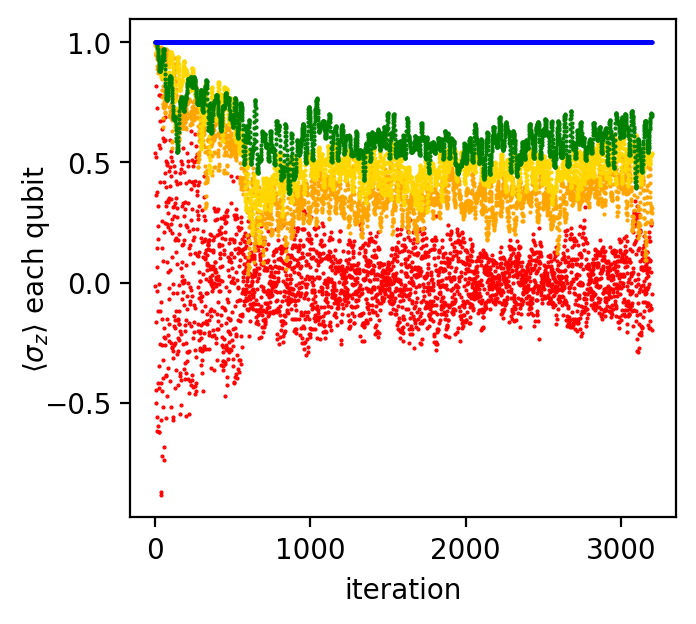

In [41]:
n_qubits = 5
epsilon = 0.1;
sim_label = 'S1c'
inter_label='SWAP'
sim1c =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq')
mtimes = 1 
nstore = 400*8
sim1c.iterate(mtimes,nstore)  # 
sigz_fig(sim1c,1000)
sim1c.simstats(1000)

0.000987882589075141 0.14868900625134615
0.42652266064330413 0.11200474147226085
0.5770244534770768 0.08486374181722436
0.9999999999990289 2.947883376570585e-13
walk_04_S1d_sz.png


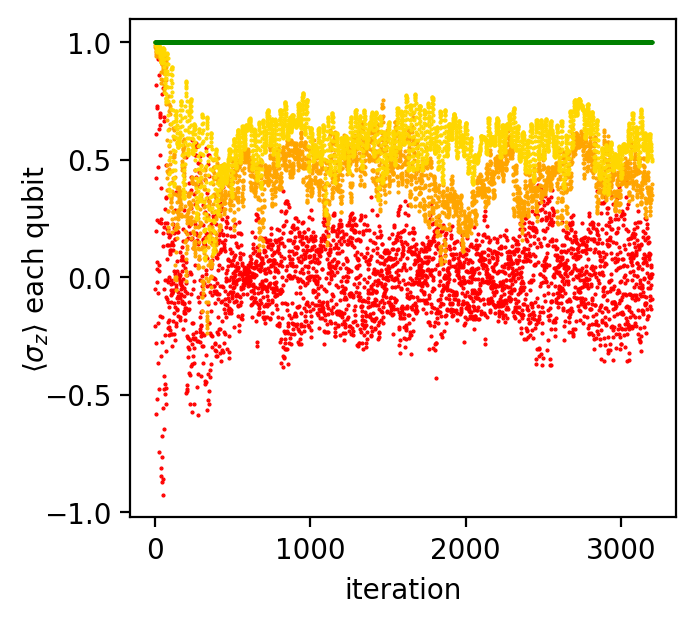

In [67]:
n_qubits = 4
epsilon = 0.1;
sim_label = 'S1d'
sim1d =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq')
mtimes = 1 
nstore = 400*8
sim1d.iterate(mtimes,nstore)  # 
sigz_fig(sim1d,1000)
sim1d.simstats(1000)

8.842844352227869e-05 0.22378770996716388
0.45897723356796255 0.17662785662626979
0.9999999999994481 1.6404235710481346e-13
walk_04_S1e_sz.png


<Figure size 640x480 with 0 Axes>

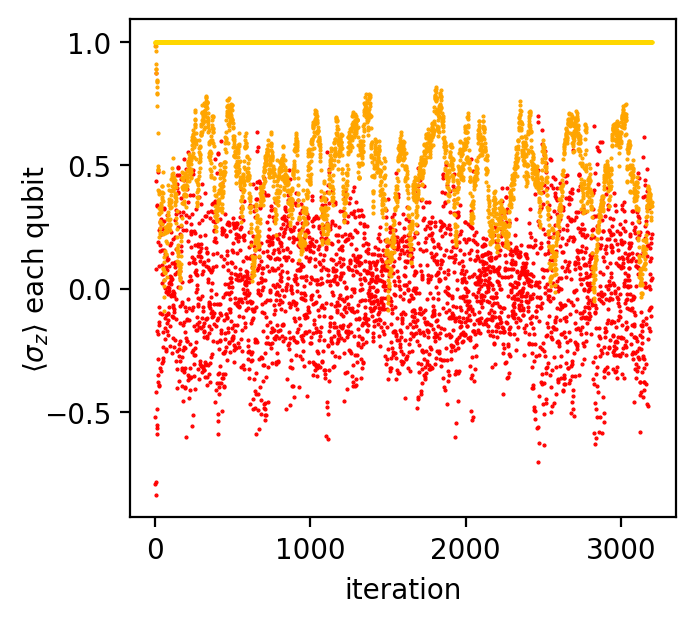

In [72]:
n_qubits = 3
epsilon = 0.1;
sim_label = 'S1e'
sim1e =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='seq')
mtimes = 1 
nstore = 400*8
sim1e.iterate(mtimes,nstore)  # 
sigz_fig(sim1e,1000)
sim1e.simstats(1000)

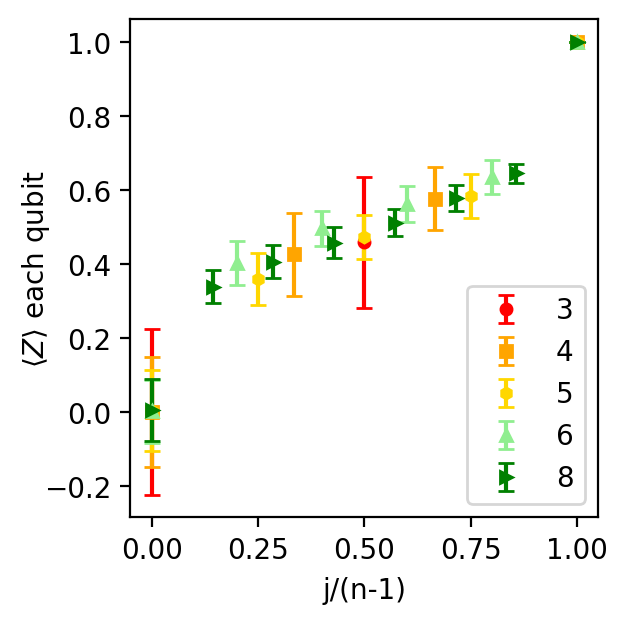

In [112]:
def mkxy(sim):
    x = np.arange(sim.n_qubits) 
    fac = sim.n_qubits -1
    x = x/fac
    y = sim.mms
    yerr = sim.sigs
    return x,y,yerr 

def nfig(simlist,ofile):
    fig,ax = plt.subplots(1,1, figsize=(3,3),dpi=200)
    plt.subplots_adjust(left=0.2,bottom=0.15,top=0.98,right=0.98)

    colorlist = ['red','orange','gold','lightgreen','green','cyan','blue','violet']
    markerlist = ['o','s','h','^','>']

    j = 0
    for sim in simlist:
        x,y,yerr = mkxy(sim)
        nlabel = '{:d}'.format(sim.n_qubits)
        ax.errorbar(x,y,yerr = yerr, fmt = markerlist[j%len(markerlist)], \
                    capsize=3,ms=4, label=nlabel,color=colorlist[j%len(colorlist)])
        j=j+1

    ax.legend()
    ax.set_ylabel(r'$\langle Z \rangle$ each qubit',labelpad=-3)
    ax.set_xlabel('j/(n-1)')

    plt.savefig(ofile)
    plt.show()

ofile = fileroot + '_ncomp.png'
simlist = [sim1e, sim1d, sim1c, sim1, sim1b]
nfig(simlist,ofile)


0.0016338435265322723 0.11051309517958274
0.3723570044774388 0.07403817418031933
0.46375715837181714 0.06236501664631158
0.5425686582248204 0.06279211075105483
0.6324313373305741 0.05421192569112285
0.999999999998584 5.022535809509226e-13
walk_03_S1b_sz.png


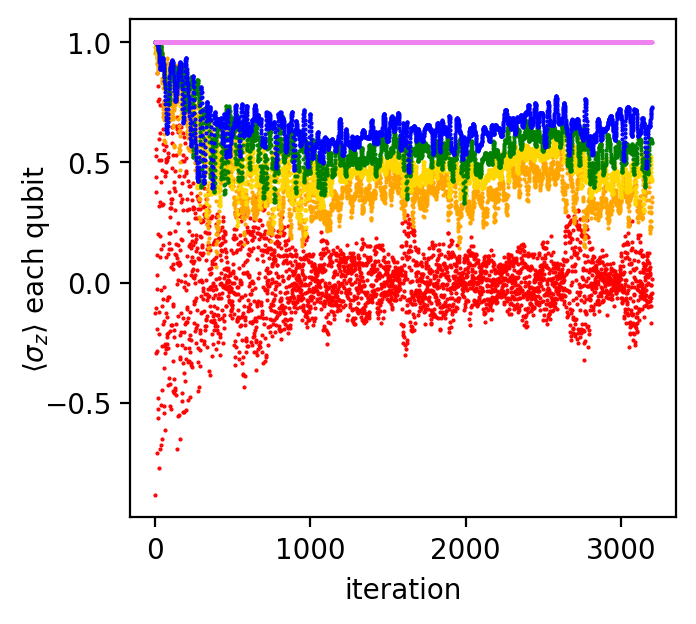

In [28]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S1br'
sim1br =  walkit(n_qubits,epsilon,Qswap,sim_label,inter_type='brick')  # brick type of interaction, not much difference 
mtimes = 1 
nstore = 400*8
sim1br.iterate(mtimes,nstore)  # 
sigz_fig(sim1br,500)
sim1br.simstats(700)

0.021416837985481257 0.2187089942350257
0.5125106862083316 0.16564051564793472
0.9999999999991431 4.955877636049842e-13
walk_04_H1_sz.png


<Figure size 640x480 with 0 Axes>

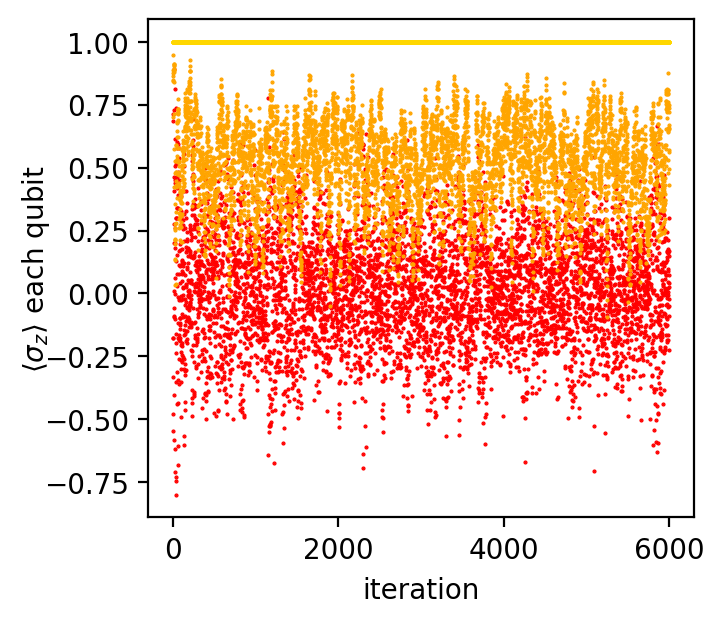

In [77]:
n_qubits = 3
epsilon = 0.1;
sim_label = 'H1'
mtimes = 1 
nstore = 400*15
simH1 = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1.iterate(mtimes,nstore)  #   
sigz_fig(simH1,0)
simH1.simstats(1000)

0.018050891900765198 0.17095503945139262
0.4465046158674275 0.13162490377407665
0.593673705904707 0.10037224343838105
0.9999999999988141 6.84792727073746e-13
walk_04_H1b_sz.png


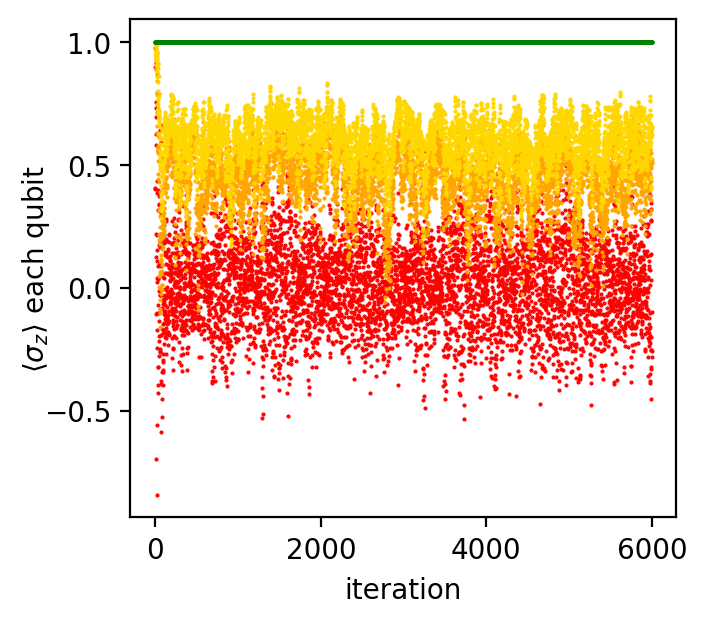

In [79]:
n_qubits = 4
epsilon = 0.1;
sim_label = 'H1b'
mtimes = 1 
nstore = 400*15
simH1b = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1b.iterate(mtimes,nstore)  #   
sigz_fig(simH1b,0)
simH1b.simstats(1000)

0.016418507425329725 0.13759268820319834
0.3994432778498186 0.10288077474563431
0.5132754829611867 0.08490193237245305
0.6204153133027128 0.0704104607440752
0.999999999998549 8.316456801090762e-13
walk_04_H1c_sz.png


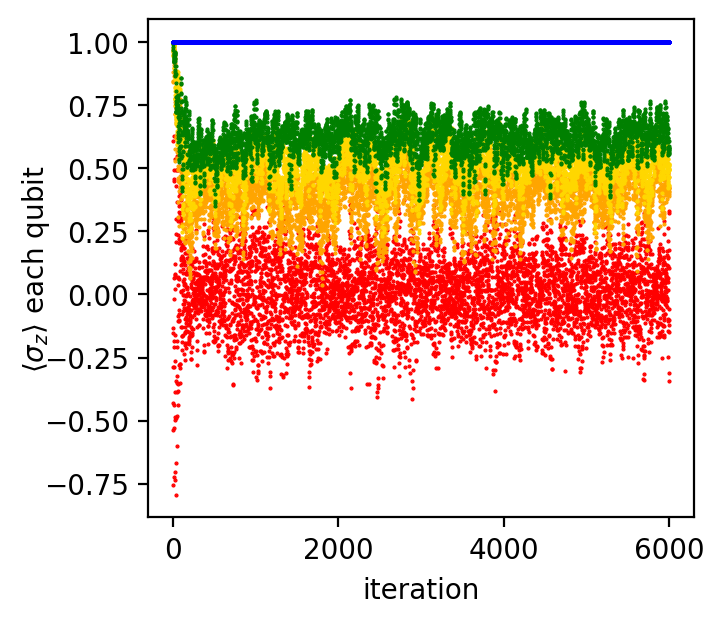

In [80]:
n_qubits = 5
epsilon = 0.1;
sim_label = 'H1c'
mtimes = 1 
nstore = 400*15
simH1c = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1c.iterate(mtimes,nstore)  #   
sigz_fig(simH1c,0)
simH1c.simstats(1000)

0.012933564661128969 0.11302645978399284
0.37071027546911195 0.0849829175796381
0.46516806914365166 0.07235158798328747
0.5453162015008521 0.0677808606155523
0.6402443120217008 0.05832944068140111
0.9999999999982113 1.0179413340584102e-12
walk_04_H1d_sz.png


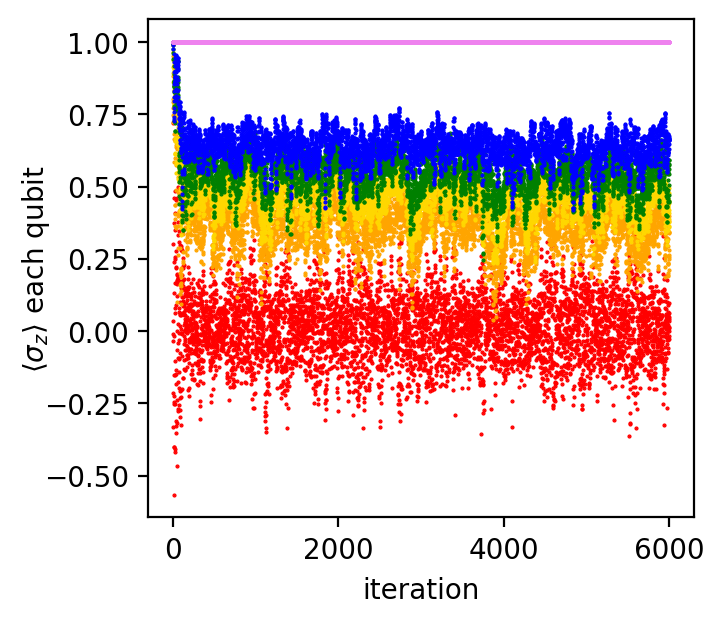

In [81]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'H1d'
mtimes = 1 
nstore = 400*15
simH1d = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1d.iterate(mtimes,nstore)  #   
sigz_fig(simH1d,0)
simH1d.simstats(1000)

0.016319167356279418 0.10018104323301297
0.3642363075660905 0.06942997506186656
0.4340169007104958 0.0639759827858437
0.4807482000206573 0.0587151894131611
0.5298782813678015 0.05188303532817835
0.5898396608164782 0.04775854516640882
0.657513043630114 0.04431882879939804
0.9999999999971221 1.3646983021968999e-12
walk_04_H1e_sz.png


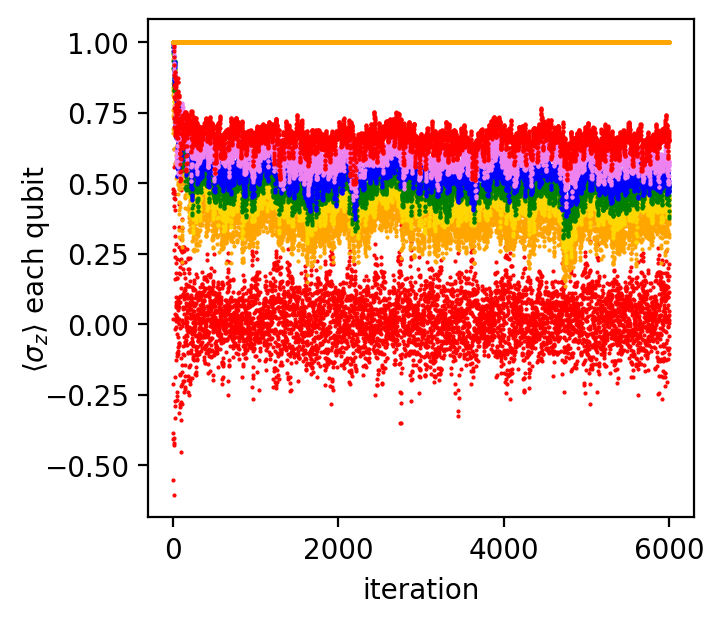

In [82]:
n_qubits = 8
epsilon = 0.1;
sim_label = 'H1e'
mtimes = 1 
nstore = 400*15
simH1e = walkit(n_qubits,epsilon,QHeis,sim_label) # 
simH1e.iterate(mtimes,nstore)  #   
sigz_fig(simH1e,0)
simH1e.simstats(1000)

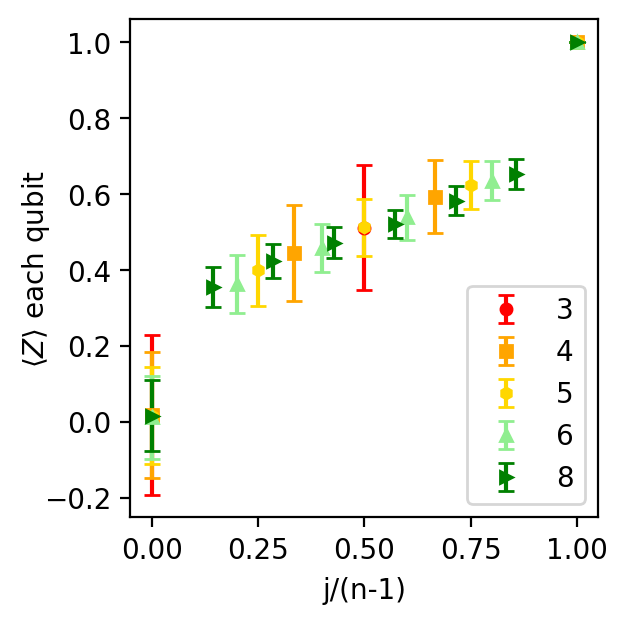

In [113]:
ofile = fileroot + '_ncomp_Heis.png'
simlist = [simH1, simH1b, simH1c, simH1d, simH1e]
nfig(simlist,ofile)


0.00951618912120489 0.10370718719825713
0.15650583825302625 0.08354108242884675
0.27297700004353315 0.06325219841487185
0.38861456340214556 0.060555607053384856
0.5469561632018048 0.05102472803039006
0.665397962368994 0.039769423442177675
0.8716745349223074 0.01750709502452356
0.9999999999991303 4.104597866525613e-14
walk_04_S8_sz.png


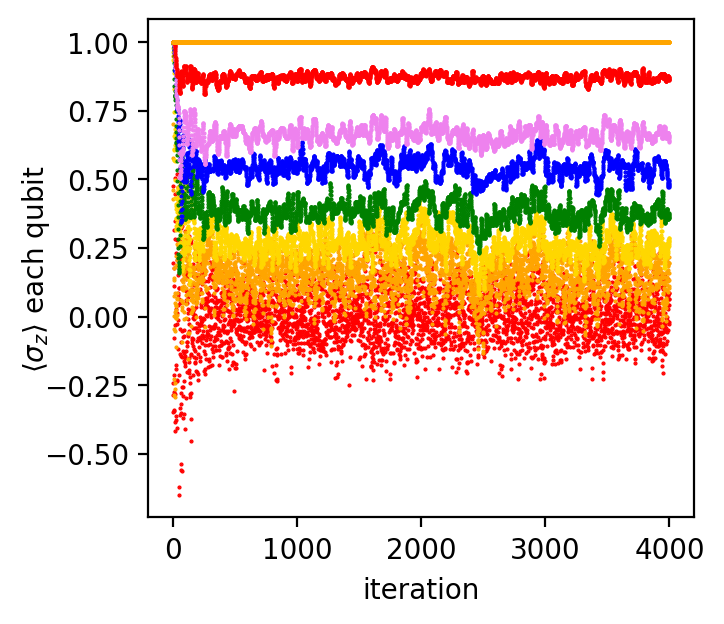

In [102]:
n_qubits = 8
epsilon_arr = np.array([0.15, 0.05, 0.05, 0.06, 0.08, 0.11, 0.15]);
sim_label = 'S8'
mtimes = 1 
nstore = 400*10
sim8 = walkit(n_qubits,epsilon_arr,QHeis,sim_label) # 

sim8.iterate(mtimes,nstore)  
sigz_fig(sim8,0)
sim8.simstats(1000)

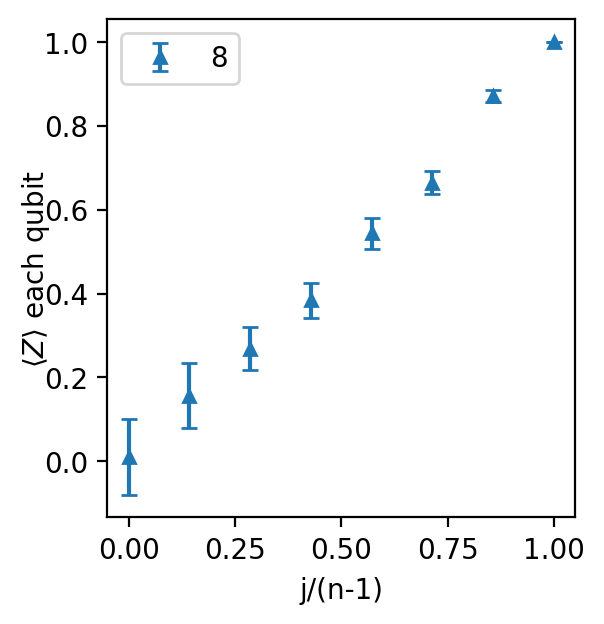

In [103]:
ofile = fileroot + '_ncomp_eps_Heis.png'
simlist = [sim8]
nfig(simlist,ofile)

0.0011007646482150662 0.15249568987272494
0.433524360177871 0.11592664507912497
0.5171635780854562 0.10561014120072626
0.5840604928617539 0.09388553699034985
0.6749932365808736 0.07141763902833695
1.00000000000115 6.96907919315695e-13
walk_03_S2_sz.png


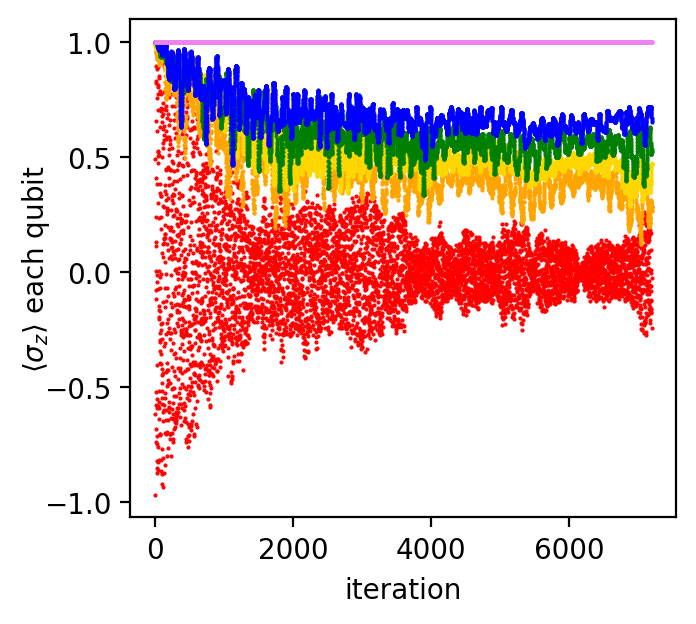

In [16]:
n_qubits = 6
epsilon = 0.05;
sim_label = 'S2'
mtimes = 1 
nstore = 400*18
sim2 =  walkit(n_qubits,epsilon,Qswap,sim_label)
sim2.iterate(mtimes,nstore)  # 
sigz_fig(sim2,500)

In [ ]:
sigz_moving_fig(sim1,200)
sigz_moving_fig(sim2,400)

0.0016376139099595977 0.11633021207207739
0.151608319930675 0.08668432550611416
0.18955710604806167 0.08078979618600006
0.2799950594623723 0.08885995197735379
0.47467810812632605 0.07750561842814388
0.9999999999992795 3.0292908502115183e-13
walk_03_S3_sz.png


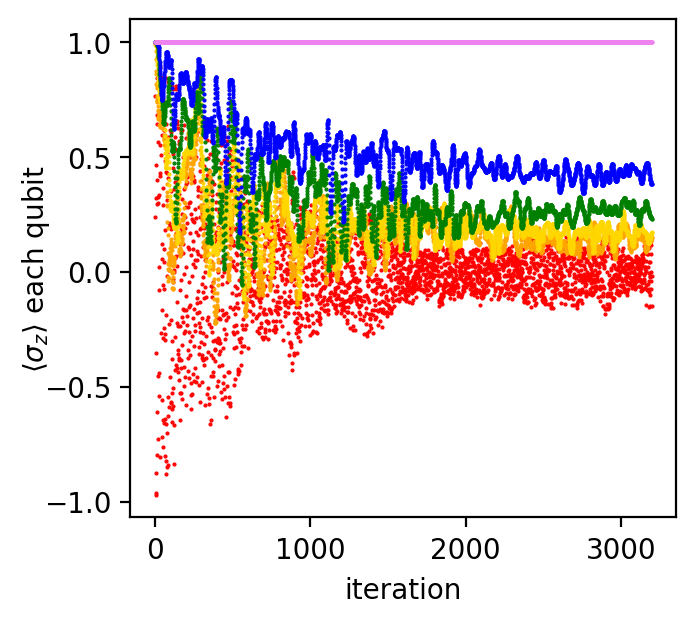

In [17]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S3'
sim3 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC0,sim_label)
#junk1.do_channel()
mtimes = 1 
nstore = 400*8
sim3.iterate(mtimes,nstore)  # 
sigz_fig(sim3,500)

0.0009977222550743398 0.12827095867004465
0.11262280540140841 0.0649290577564203
0.1544347320748384 0.07802752213627392
0.18396002460837416 0.06515840027838805
0.2984075326630738 0.07761504118235384
0.9999999999993631 2.4584765328144787e-13
walk_03_S4_sz.png


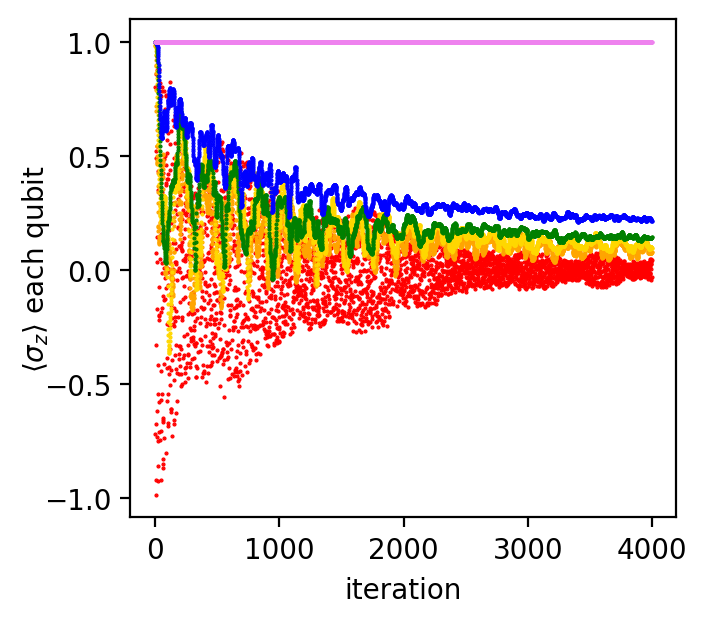

In [18]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S4'
mtimes = 1 
nstore = 400*10
sim4 =  walkit(n_qubits,epsilon,0.2*Qswap+0.8*QCnotC0,sim_label)
#junk1.do_channel()
sim4.iterate(mtimes,nstore)  # 
sigz_fig(sim4,500)

0.0015452527265299193 0.13363297532158377
0.2900483894394576 0.09934908361215403
0.25997476224457006 0.09032824446351871
0.28425009122188644 0.10016888944515229
0.4181716738296318 0.08983283520324764
1.0 1.805513236600925e-16
walk_03_S5_sz.png


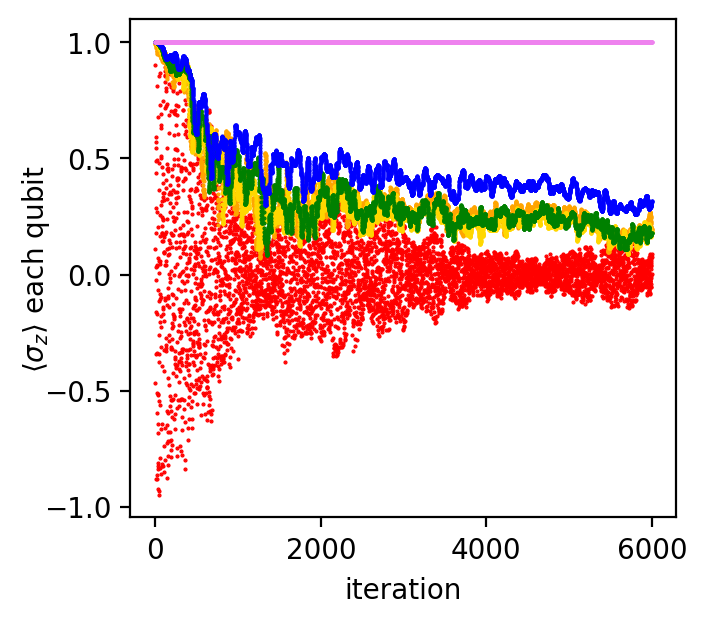

In [21]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S5'
mtimes = 1 
nstore = 400*15
sim5 =  walkit(n_qubits,epsilon,0.5*Qswap+0.5*QCnotC1,sim_label)
#junk1.do_channel()
sim5.iterate(mtimes,nstore)  # 
sigz_fig(sim5,500)

0.0041867162746669845 0.21213466220108038
0.5193514134995871 0.15326642141408978
0.5214835328811721 0.13636764376186084
0.5207136626453319 0.13687014735800213
0.5233837450128402 0.14740653968777193
1.0 1.864141070515652e-16
walk_03_S6_sz.png


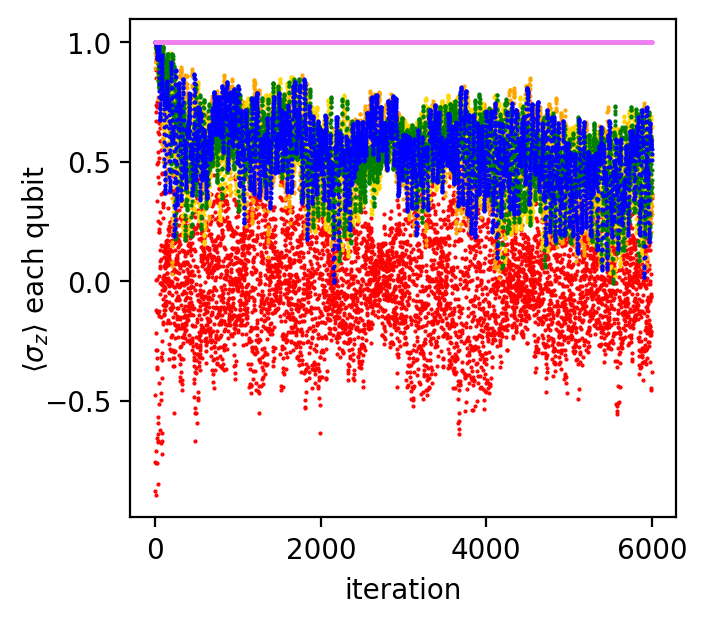

In [22]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S6'
mtimes = 1 
nstore = 400*15
sim6 =  walkit(n_qubits,epsilon,Qswap_short,sim_label)
sim6.iterate(mtimes,nstore)  # 
sigz_fig(sim6,500)

In [23]:
n_qubits = 6
epsilon = 0.1;
sim_label = 'S7'
mtimes = 1 
nstore = 400*15
sim7 = walkit(n_qubits,epsilon,QHeis,sim_label)
sim7.do_channel()
#sim7.iterate(mtimes,nstore)  # 
#sigz_fig(sim7,500)

0.008278452252362591 0.2348370040638718
0.520943116599222 0.16084819637197642
1.0 1.0433089591669239e-16
walk_03_T1_sz.png


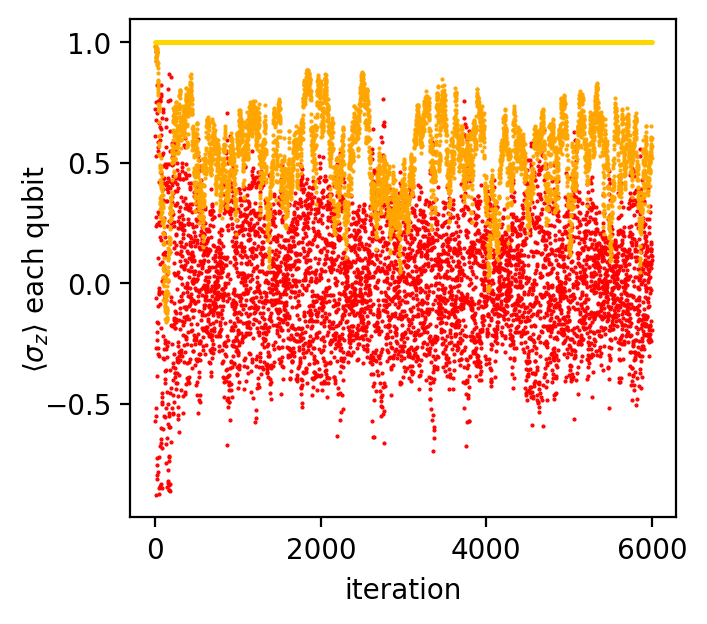

In [24]:
n_qubits = 3
epsilon = 0.1;
sim_label = 'T1'
mtimes = 1 
nstore = 400*15
tsim1 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim1.iterate(mtimes,nstore)  # 
sigz_fig(tsim1,500)

0.0005774545396559916 0.27373965675317
0.44919193298601007 0.16244509569959056
1.0 1.0219681840978395e-16
walk_03_T2_sz.png


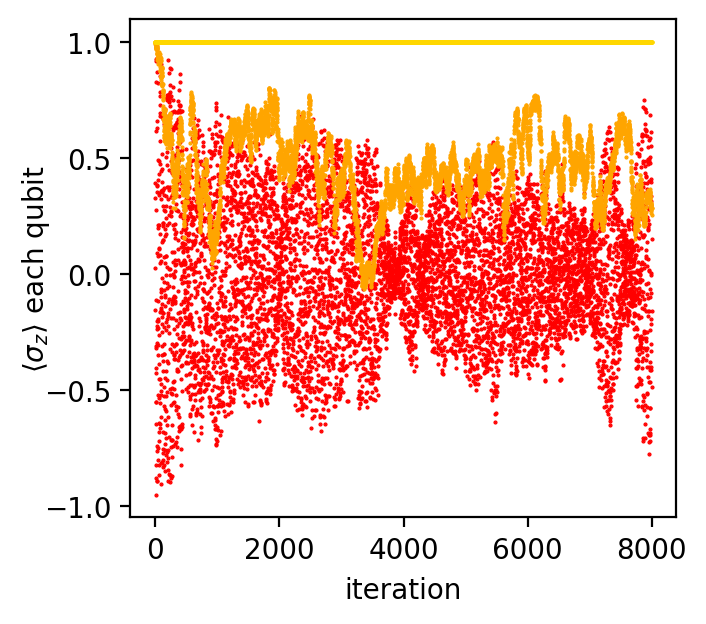

In [25]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T2'
mtimes = 1 
nstore = 400*20
tsim2 =  walkit(n_qubits,epsilon,1.0*Qswap+0.0*QCnotC0,sim_label)
tsim2.iterate(mtimes,nstore)  # 
sigz_fig(tsim2,500)

0.0009273430876544154 0.2147095125968403
0.348319143993072 0.16572754577721685
0.9999999999991364 4.3806219640886056e-13
walk_02_T3_sz.png


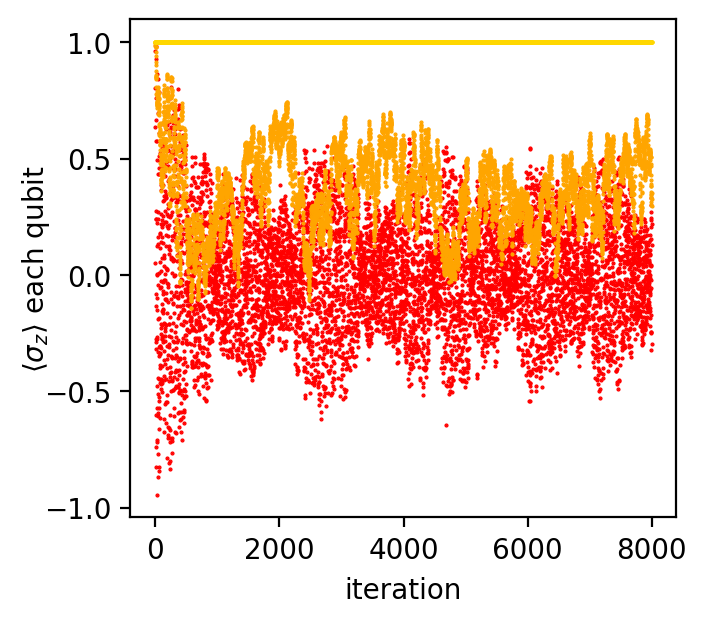

In [107]:
n_qubits = 3
epsilon = 0.05;
sim_label = 'T3'
mtimes = 1 
nstore = 400*20
tsim3 =  walkit(n_qubits,epsilon,1*Qswap+1*QCnotC0,sim_label)
tsim3.iterate(mtimes,nstore)  # 
sigz_fig(tsim3,500)

## everything below is garbage for testing 

0.10033534773107558 1.4722194895832204


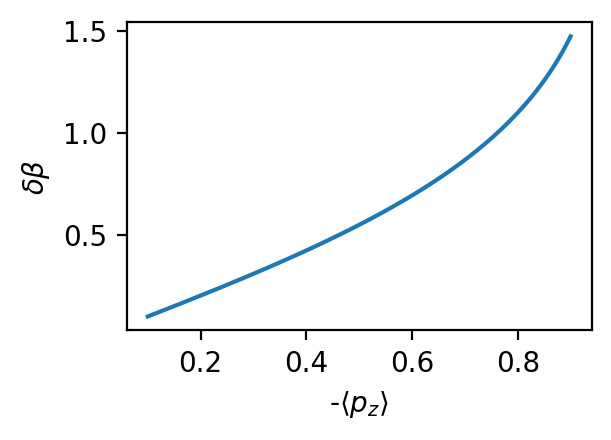

In [67]:
xlin = np.linspace(0.1,0.90,100)
ylin = np.arctanh(xlin)
fig,ax = plt.subplots(1,1,figsize=(3,2),dpi=200)
print(min(ylin),max(ylin))

ax.plot(xlin,ylin)
ax.set_ylabel(r'$\delta \beta$')
ax.set_xlabel(r'-$\langle p_z \rangle$')

plt.show()

In [ ]:
# series is a 1 array, d is a window length (integer)
# make a moving average of both mean and dispersion around mean
from scipy import ndimage
def stats_window(series,dwindow):
    ns = len(series)
    moving_ave = ndimage.uniform_filter(series, size=dwindow,mode='constant')
    remainder = (series - moving_ave)**2
    moving_sig2 = ndimage.uniform_filter(remainder, size=dwindow,mode='constant')
    moving_sig = np.sqrt(moving_sig2+1e-6)
    return moving_ave,moving_sig

def sigz_moving_fig(sim,dwindow):
    colorlist = ['red','orange','gold','green','blue','violet','brown','gray']
    nc = len(colorlist)
    fig,ax = plt.subplots(1,1,figsize=(3.5,3),dpi=200)
    plt.subplots_adjust(bottom=0.15,left=0.2,top=0.98,right=0.98)
    #i0=500
    mz0 = np.squeeze(sim.mz_store[0:,0])
    nit = np.arange(len(mz0))
    di=int(dwindow/2)
    for j in range(n_qubits):
        mz = np.squeeze(sim.mz_store[0:,j])
        moving_ave,moving_sig = stats_window(mz,dwindow)
        #print(np.mean(mz[i0:]),np.std(mz[i0:]))
        #ax.plot(nit,mz,'.',color=colorlist[j%nc],ms=1)
        plt.errorbar(nit[2*di:-2*di:di],moving_ave[2*di:-2*di:di],yerr=moving_sig[2*di:-2*di:di],capsize=3,color=colorlist[j%nc])
    ax.set_xlabel('iteration')
    ax.set_ylabel(r'$\langle \sigma_z \rangle$ each qubit',labelpad=-3)
    ofile = fileroot+sim.sim_label+'_szmov.png'
    print(ofile)
    plt.savefig(ofile)
    plt.show()

